In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import cv2
from pathlib import Path
import polars as pl
import pyarrow.parquet as pq

from combra import stats as cstats
from combra import approx as capprox
from combra import image as cimage
from combra import contours as ccontours
from combra import data as cdata 

from combra.contours import contour_to_binary_mask

# Generate data

In [ ]:
poliamid_path = "data/autumn/images"

output_path = "poliamid_group_250.parquet"

poliamid_dataset = cdata.PoliamidDataset(poliamid_path)

poliamid_dataset.generate(n_jobs=23, out_path=output_path,N=1_000_000)

In [ ]:

poliamid_path = "data/autumn/images"

for N in [50,100,500,1000]:

    poliamid_dataset = cdata.PoliamidDataset(poliamid_path)

    poliamid_dataset.generate(n_jobs=23, out_path=f"poliamid_group250_n{N}.parquet",N=N)

# Images fractal dimention

  0%|          | 0/2 [00:00<?, ?it/s]

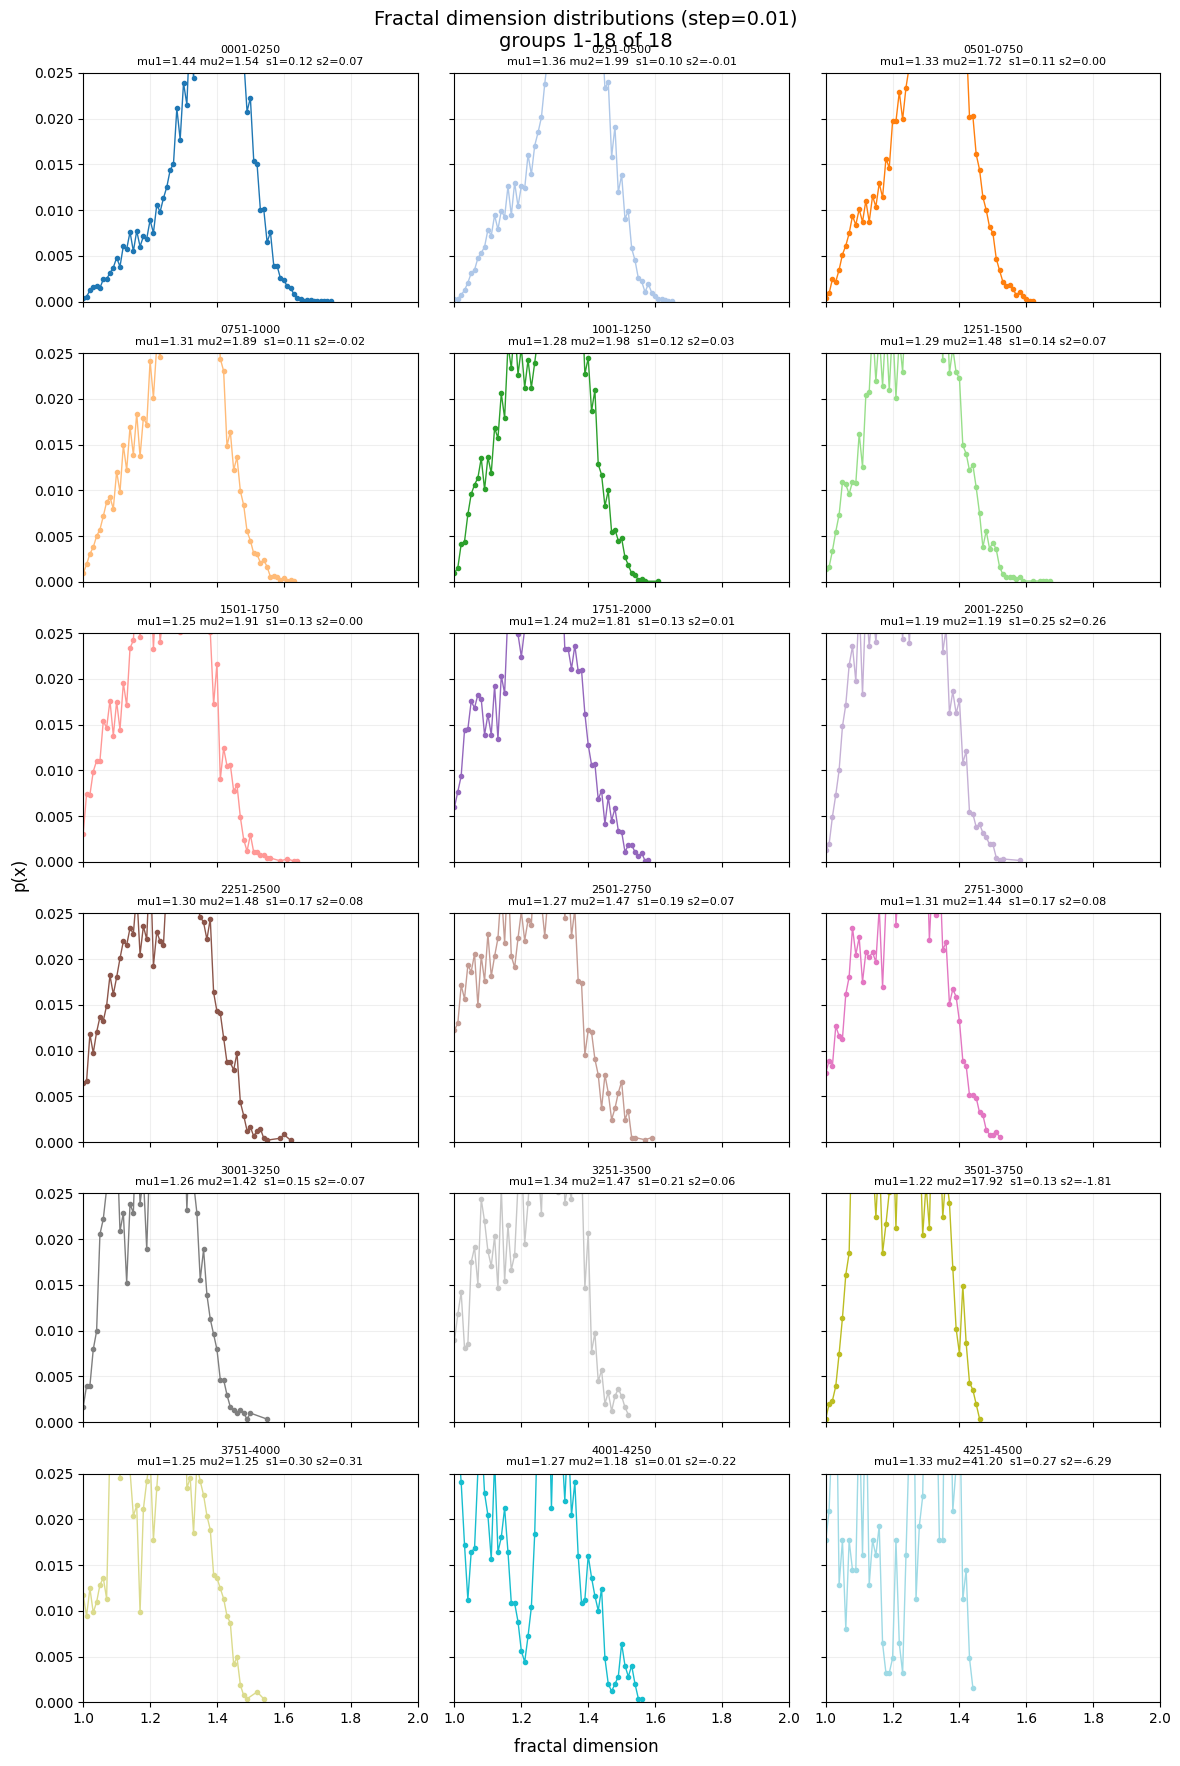

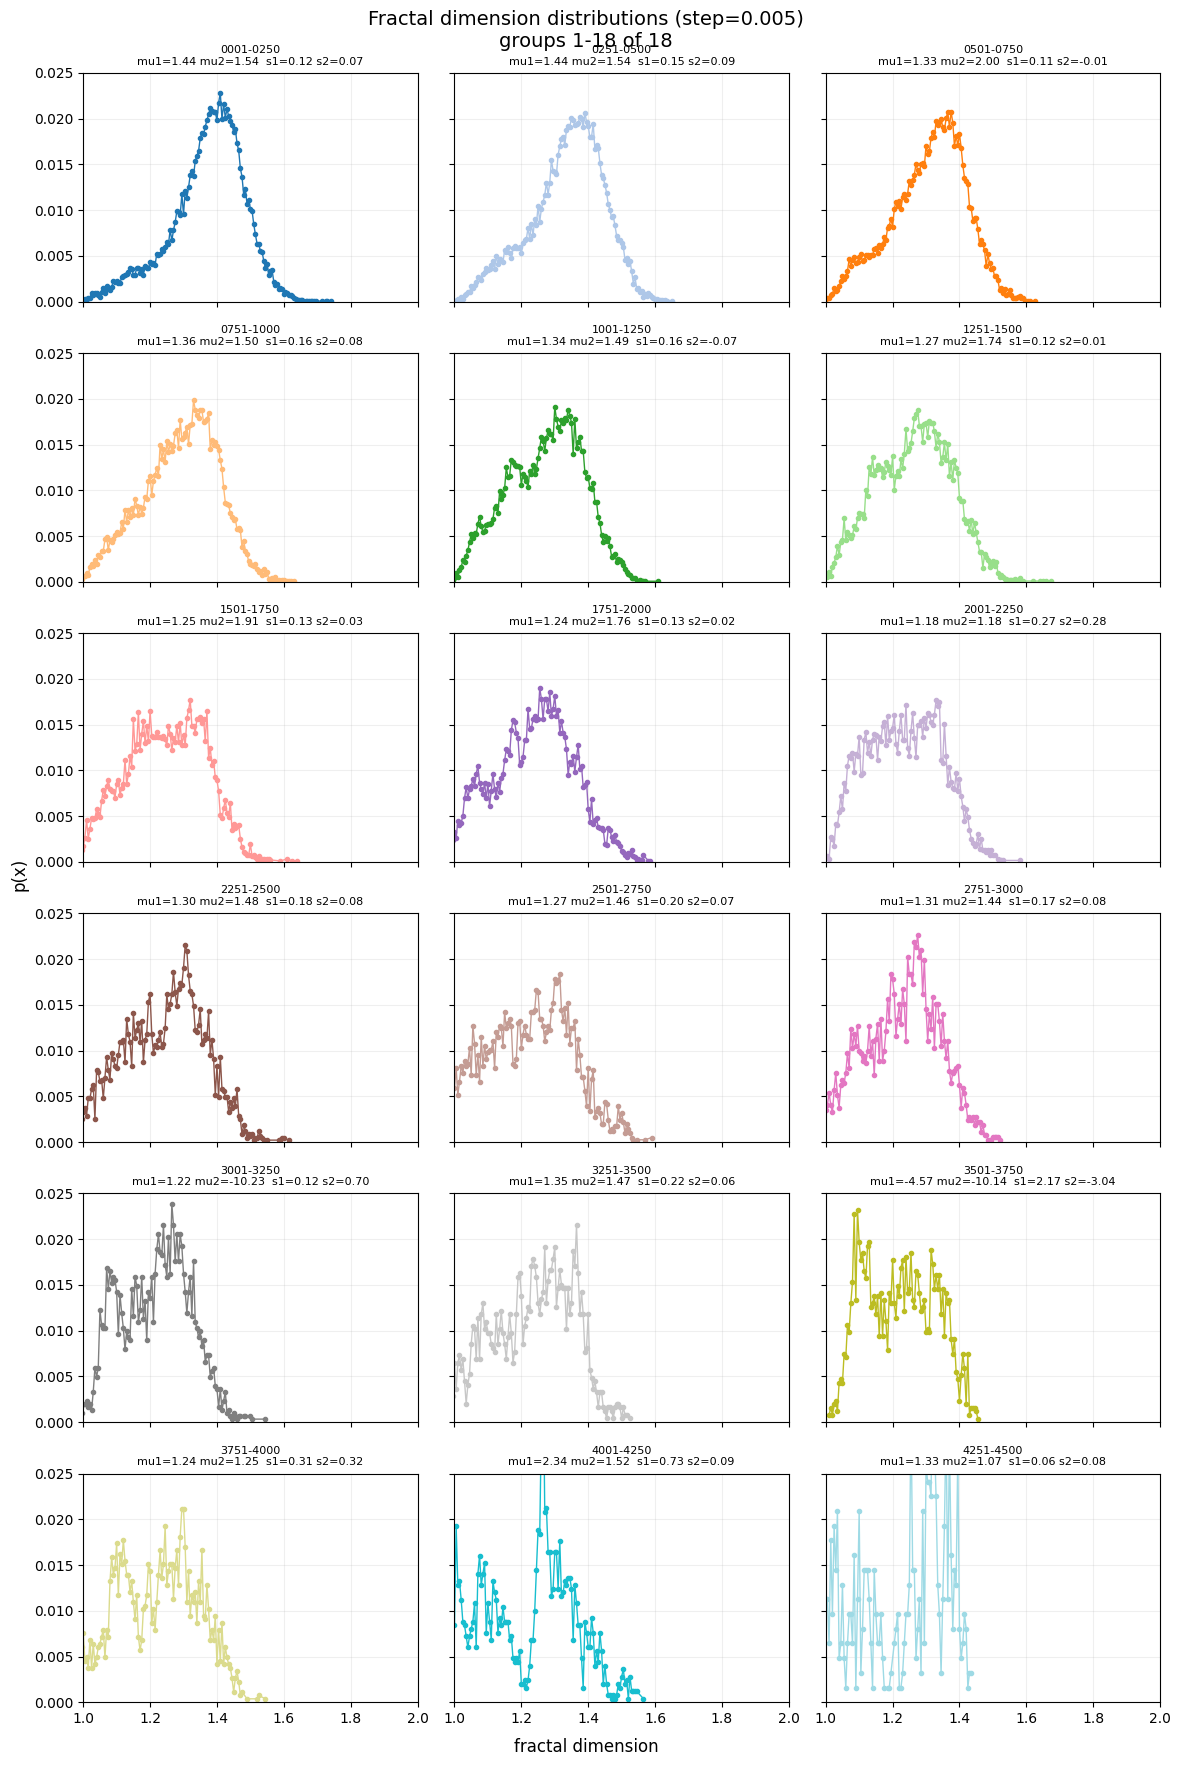

  0%|          | 0/2 [00:00<?, ?it/s]

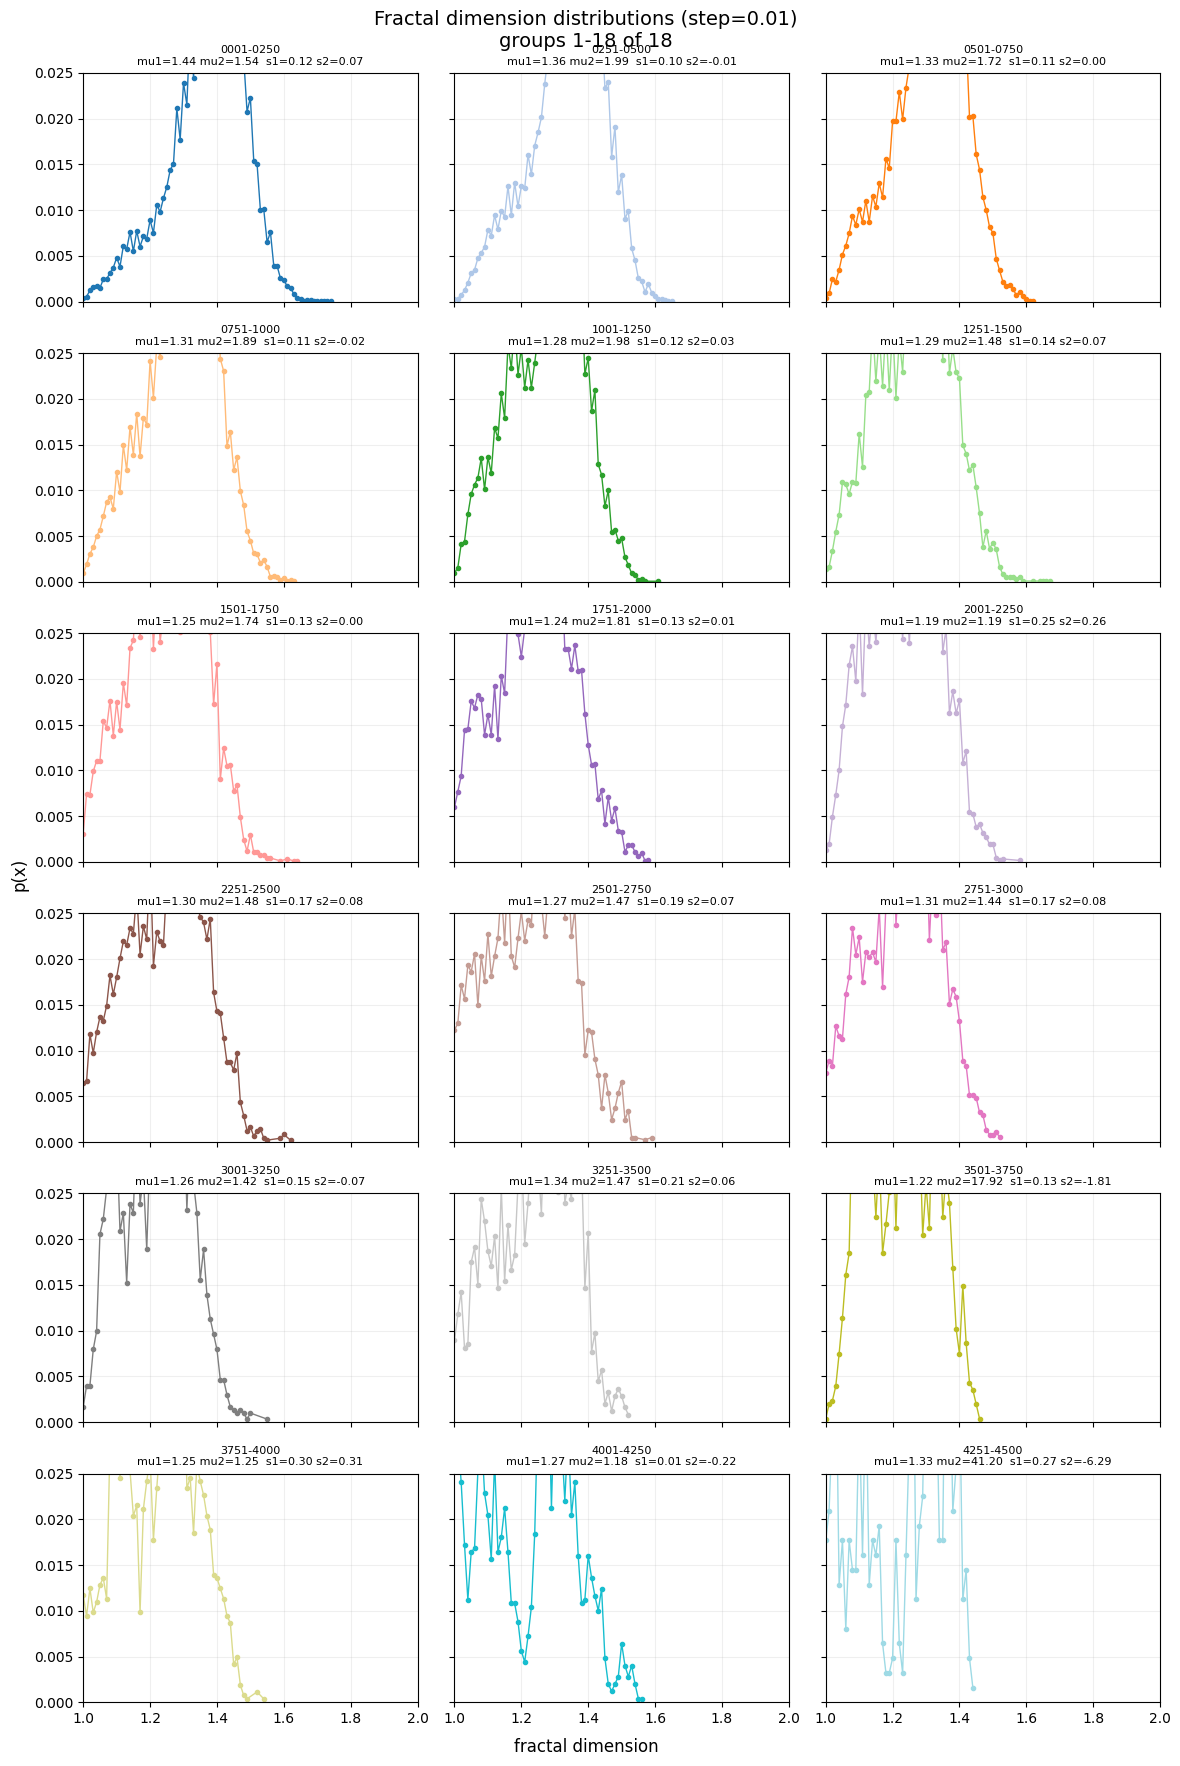

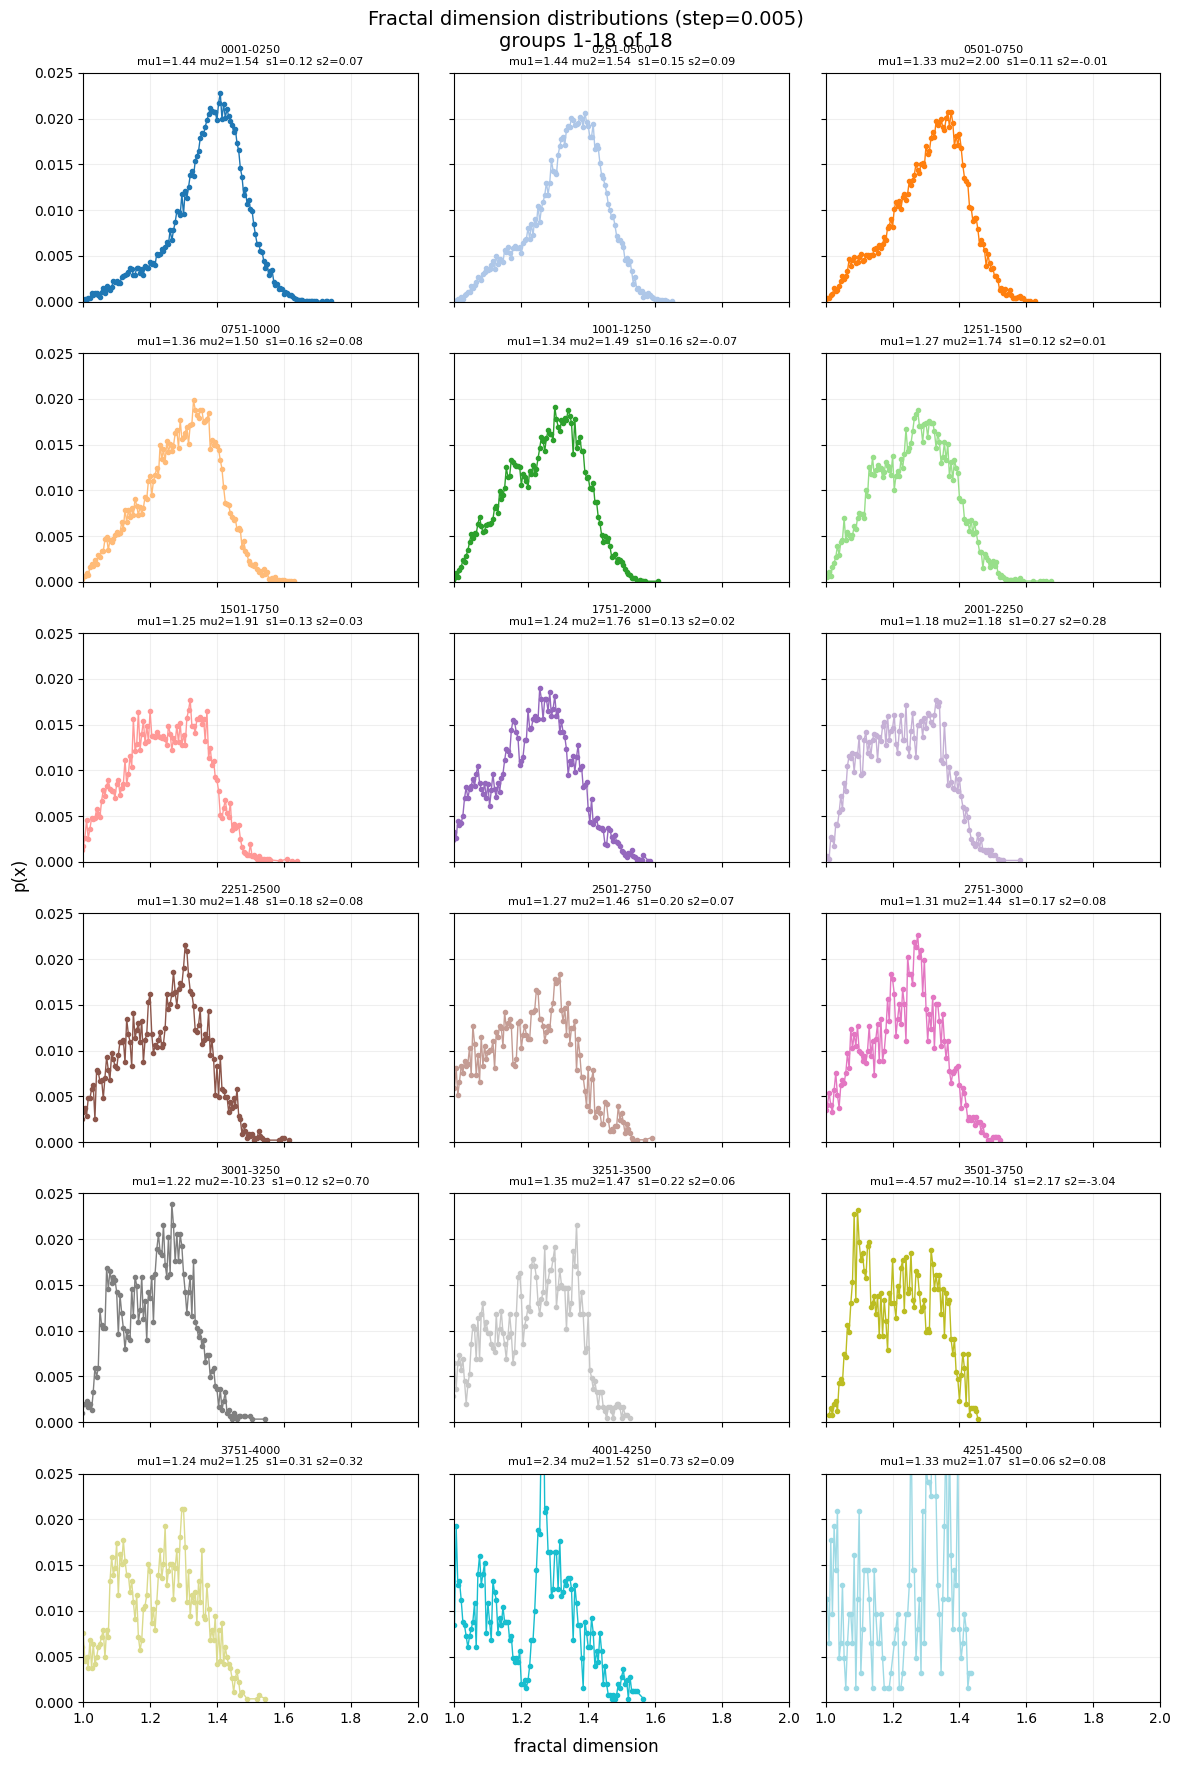

  0%|          | 0/2 [00:00<?, ?it/s]

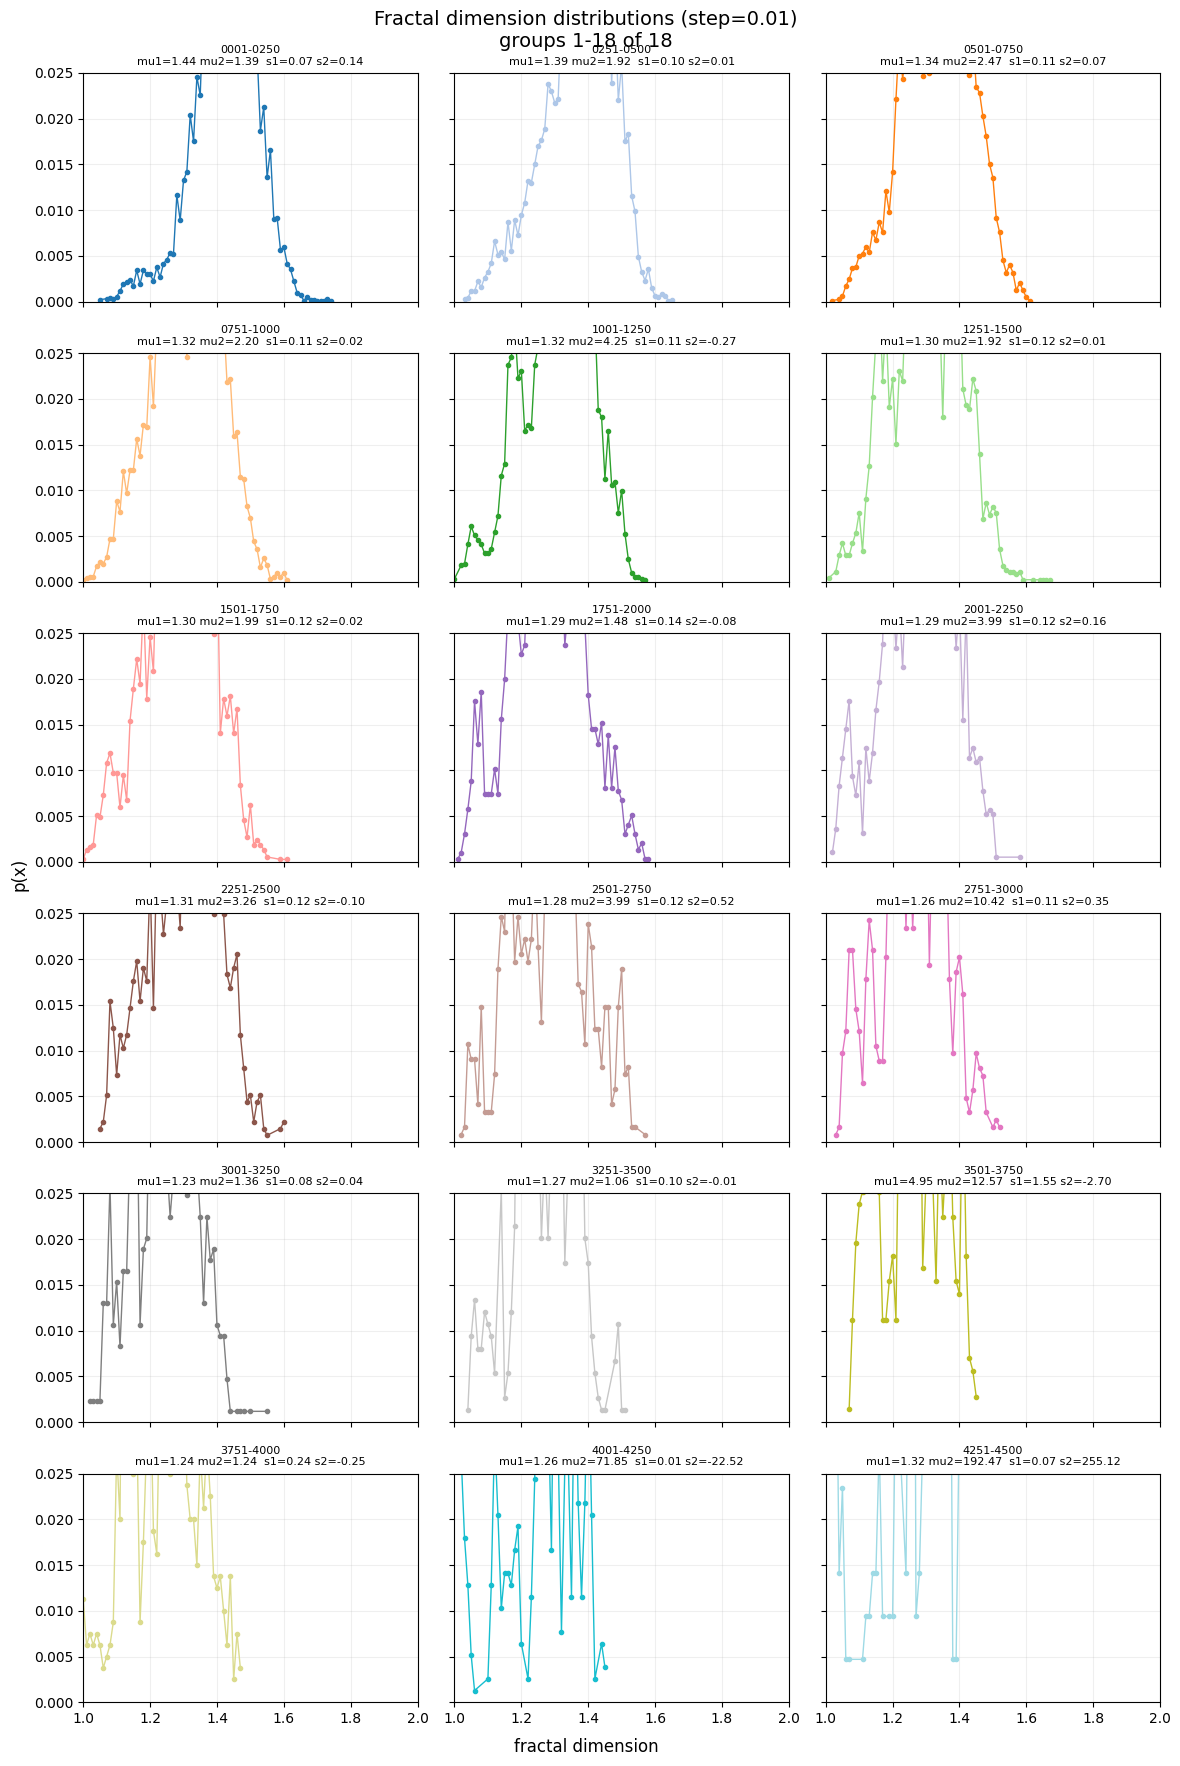

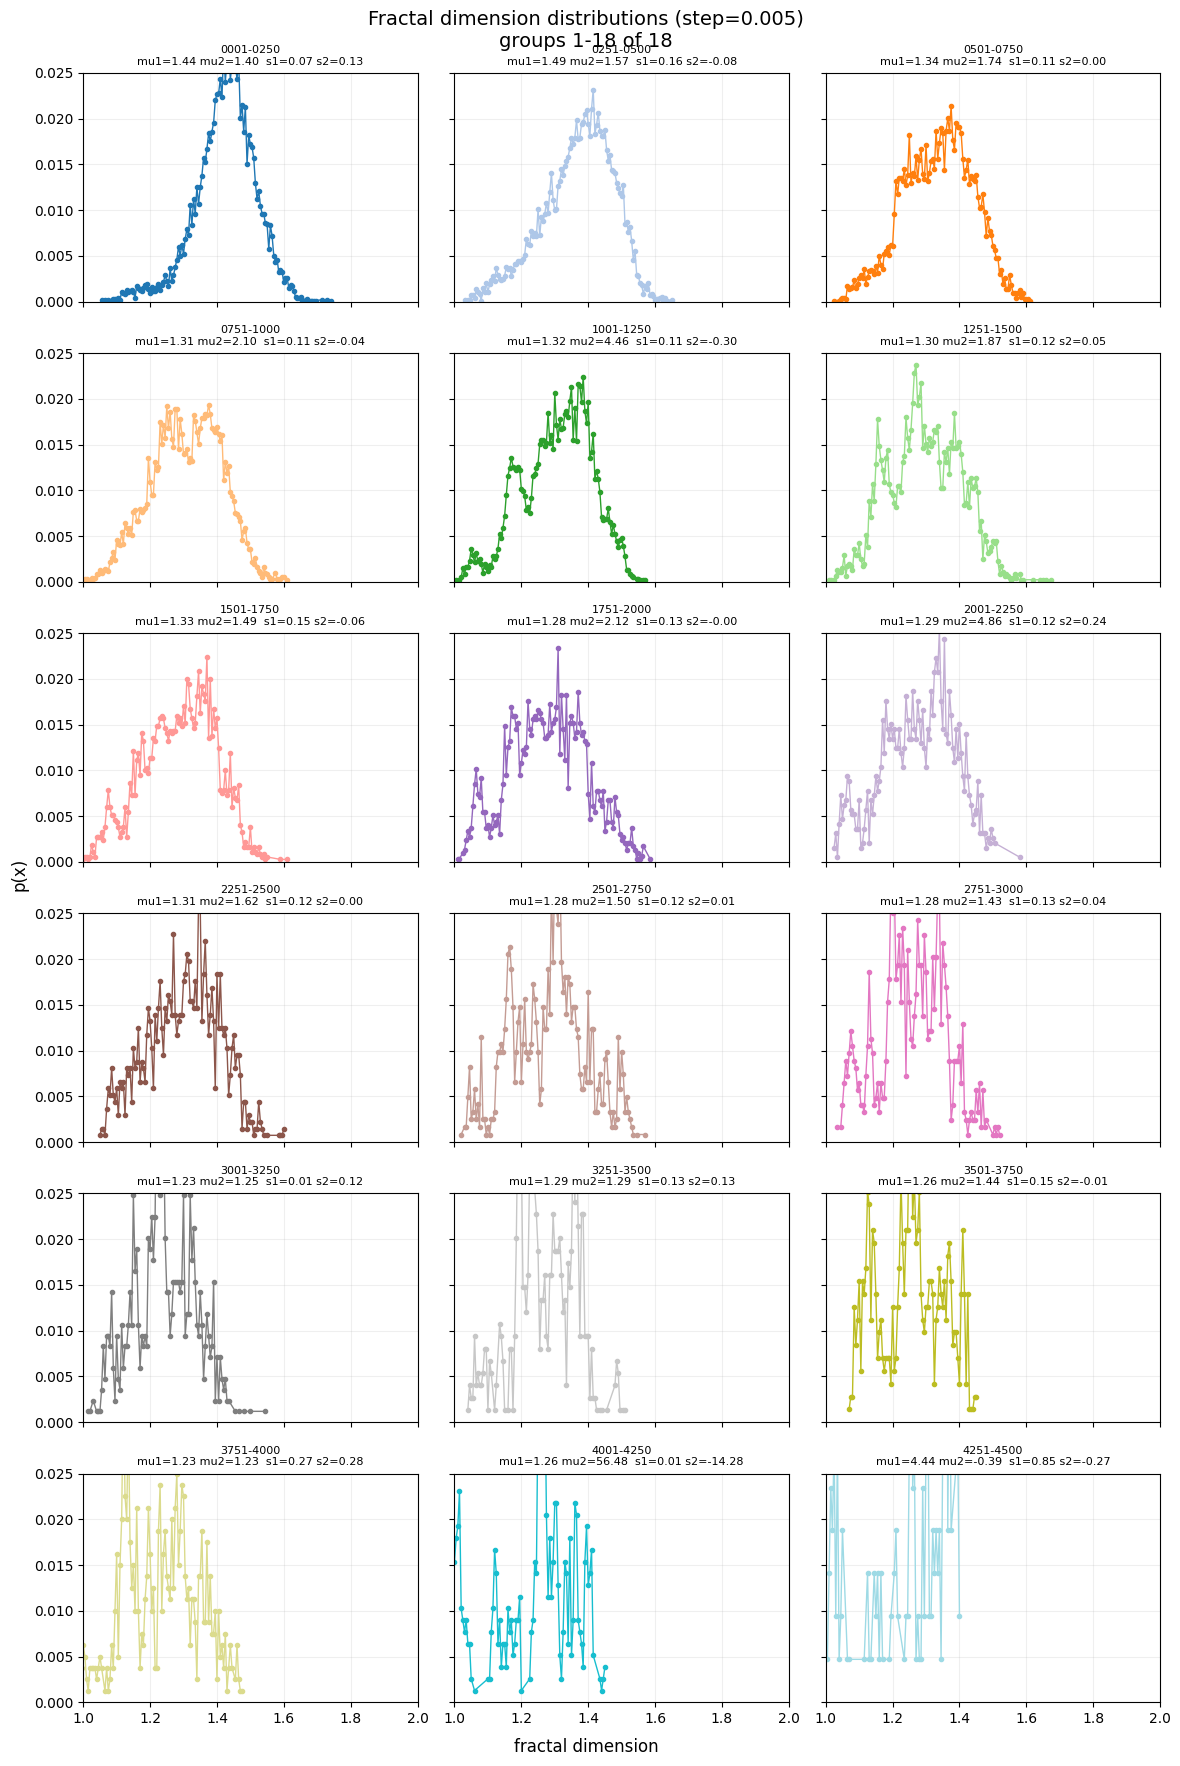

  0%|          | 0/2 [00:00<?, ?it/s]

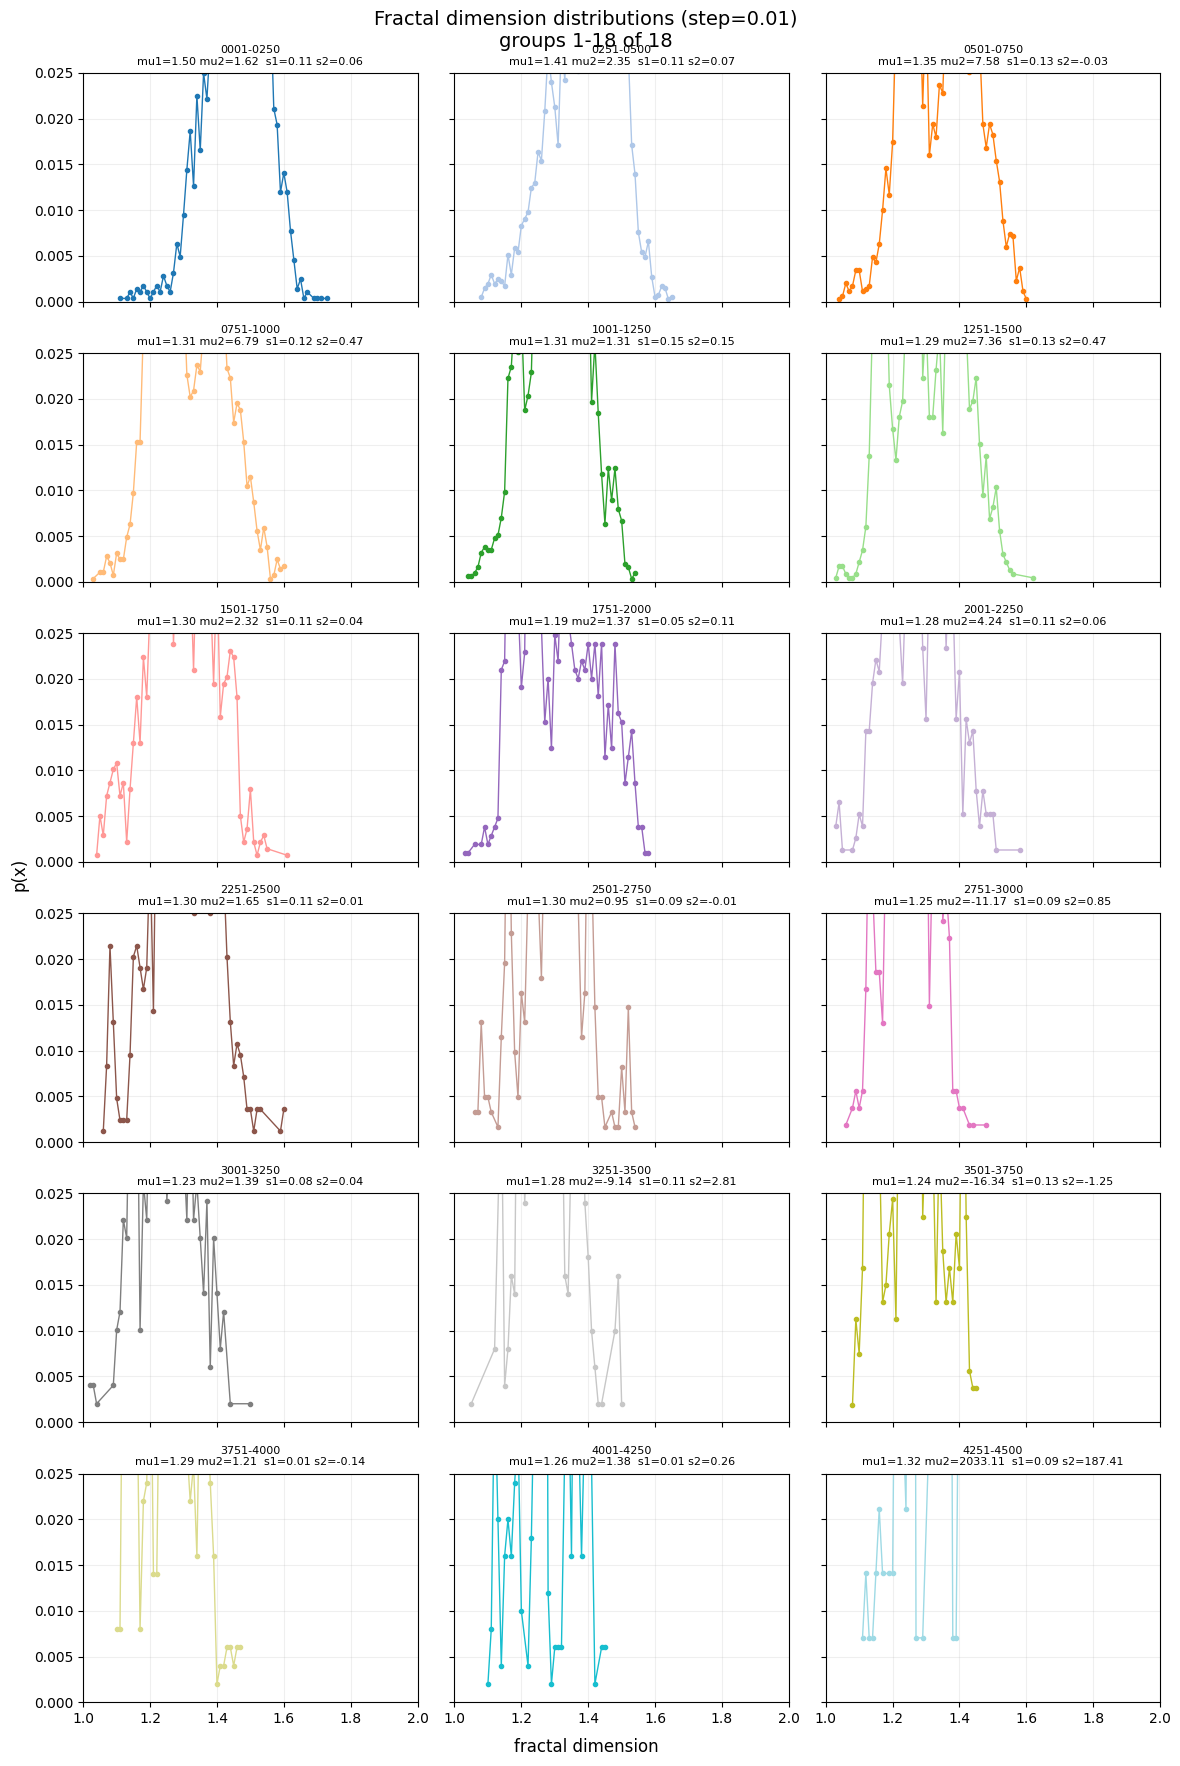

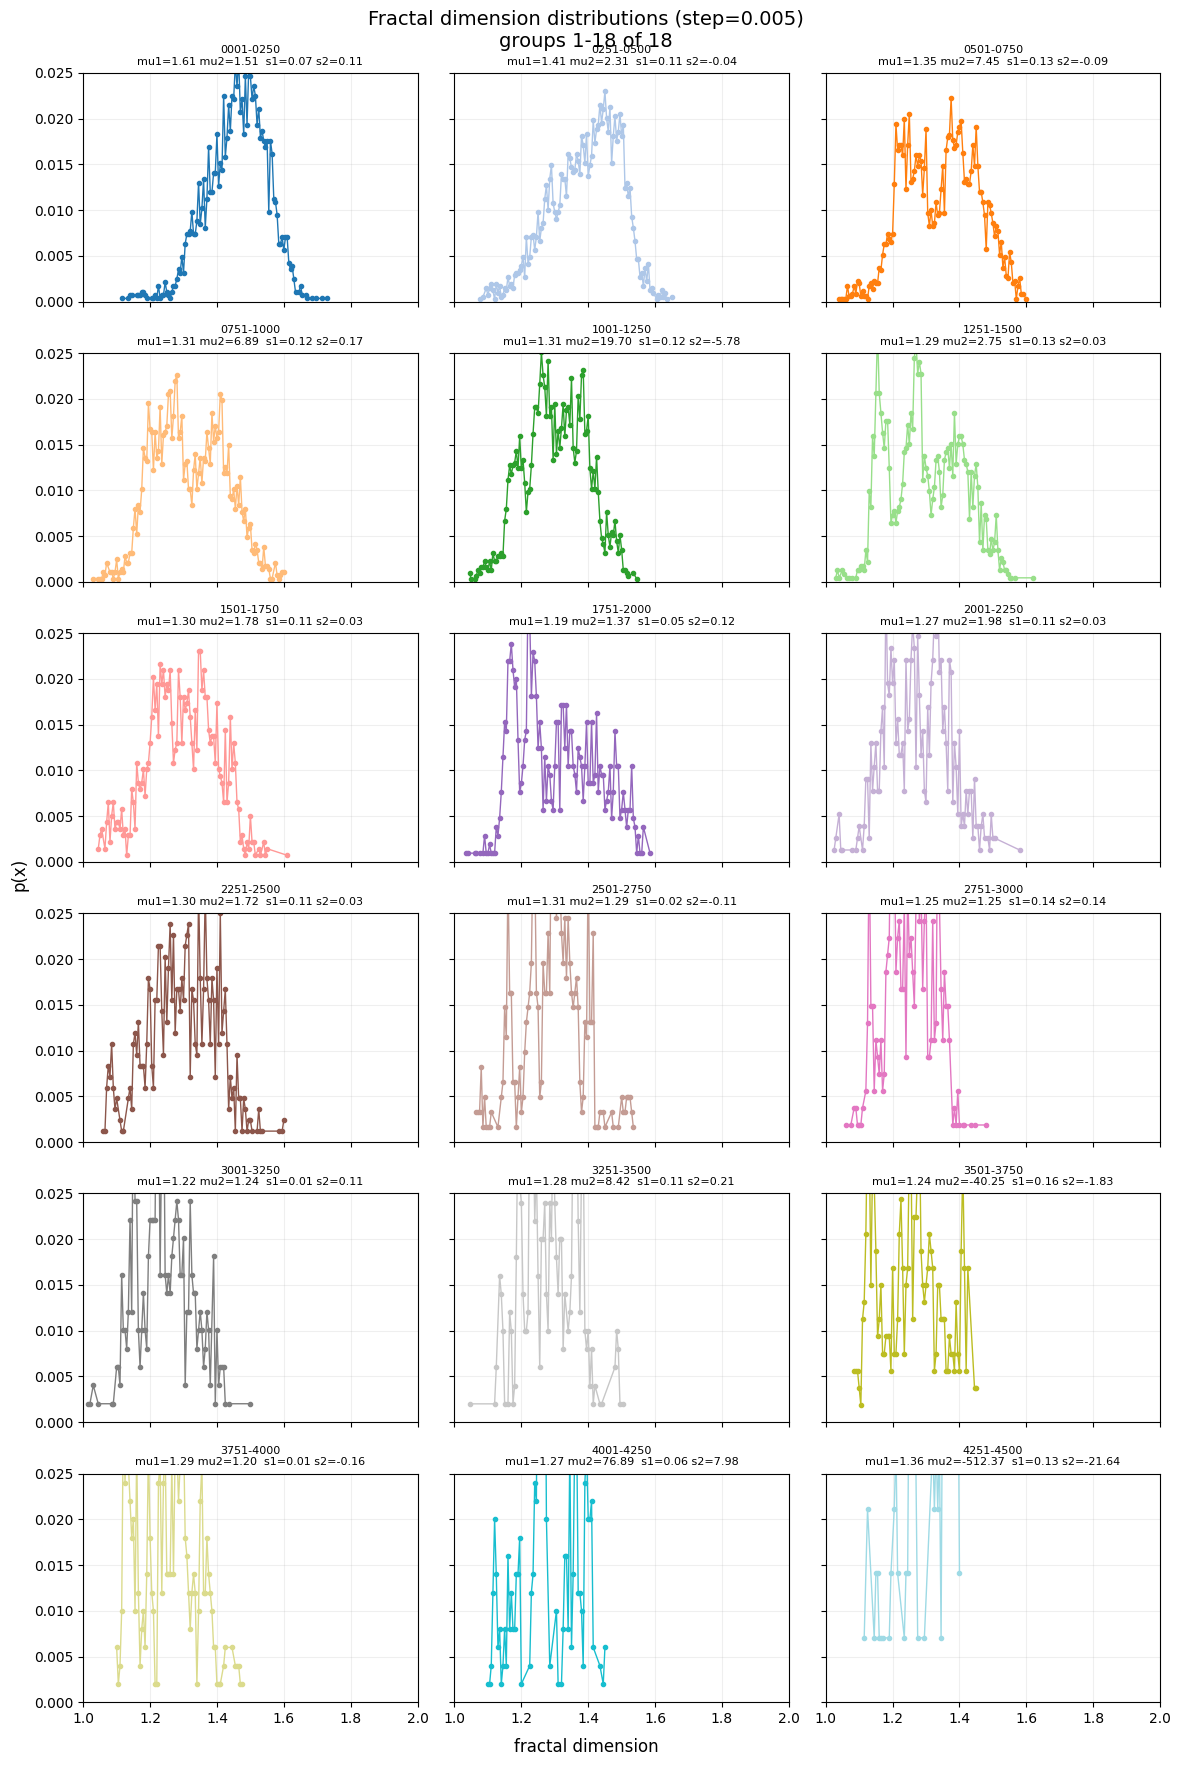

In [ ]:
def plot_fractal_base(path):

    in_path = Path(path)

    df = pl.read_parquet(in_path)
    groups = df.to_dicts()
    group_labels = df["group_label"].to_list()

    # bin size for stats_preprocess

    nrows, ncols = 6, 3
    page_size = nrows * ncols

    # for step in tqdm([ 0.001, 0.005, 0.01]):
    for step in tqdm([ 0.005]):
    for step in tqdm([ 0.01]): 

        # Colors per group (will cycle if many groups)
        colors = plt.cm.tab20(np.linspace(0, 1, max(2, min(20, len(groups)))))

        # If there are more than 18 groups, page across multiple 3x6 figures
        for page_start in range(0, len(groups), page_size):
            page_groups = groups[page_start : page_start + page_size]

            fig, axes = plt.subplots(
                nrows,
                ncols,
                figsize=(ncols * 4, nrows * 3),
                sharex=True,
                sharey=True,
            )
            axes = np.asarray(axes).ravel()

            # Hide unused axes on the last page
            for ax in axes[len(page_groups) :]:
                ax.axis("off")

            for i, g in enumerate(page_groups):
                ax = axes[i]
                idx = page_start + i

                fd_list = g.get("fd_list", [])
                if fd_list is None:
                    fd_list = []
                else:
                    fd_list = list(fd_list)

                color = colors[idx % len(colors)]

                ax.set_xlim(1, 2)

                # step 0.0005
                # ax.set_ylim(0, 0.01)
                # step 0.001
                # ax.set_ylim(0, 0.008)
                # step 0.005
                ax.set_ylim(0, 0.025)


                ax.grid(True, alpha=0.2)

                if not fd_list:
                    ax.set_title(f"{g.get('group_label', '')}\n(no data)", fontsize=9)
                    continue

                x_orig, y_orig = cstats.stats_preprocess(fd_list, step)

                (x_fit, y_fit), mus, sigmas, amps = capprox.bimodal_gauss_approx(
                    x_orig,
                    y_orig,
                    mu1=1.2,
                    mu2=1.8,
                    sigma1=0.1,
                    sigma2=0.1,
                    amp1=1,
                    amp2=1,
                )

                ax.plot(x_orig, y_orig, "-o", color=color, markersize=3, linewidth=1)
                # ax.plot(x_fit, y_fit, "--", color=color, linewidth=1, alpha=0.8)

                ax.set_title(
                    f"{g['group_label']}\n"
                    f"mu1={mus[0]:.2f} mu2={mus[1]:.2f}  s1={sigmas[0]:.2f} s2={sigmas[1]:.2f}",
                    fontsize=8,
                )

            fig.suptitle(
                f"Fractal dimension distributions (step={step})\n"
                f"groups {page_start + 1}-{page_start + len(page_groups)} of {len(groups)}",
                fontsize=14,
            )
            fig.supxlabel("fractal dimension", fontsize=12)
            fig.supylabel("p(x)", fontsize=12)

            plt.tight_layout()

            plt.savefig(f'{path.split(".")[0]}_step={step}_page={page_start // page_size + 1}.jpg', bbox_inches='tight')
            plt.show()


for N in [50,100,500,1000]:

    path = f"poliamid_group250_n{N}.parquet"
    plot_fractal_base(path)